# Lab 3 - Models of visual attention

Created by : Alexandre Bruckert / University of Nantes - alexandre.bruckert@univ-nantes.fr

Date : 2024

In this lab, we will study a few models of visual attention, and evaluate their performances.

#### 0) Imports from previous labs

In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import gaussian_filter
import cv2

# Add path to import Itti_Koch
sys.path.insert(0, './')
from Itti_Koch import IttiSaliency

# Lab 2
def range_normalize(x):
    """Normalizes x to [0, 1]"""
    x = (x - x.min()) / (x.max() - x.min())
    return x

def sum_normalize(x):
    """Normalizes x so that it sums to 1"""
    return x / x.sum()

def std_normalize(x):
    return (x - np.mean(x)) / np.std(x)

def log_density(saliencyMap, eps=np.spacing(1.0)):
    """Transforms a non probabilistic saliency map into a log density"""
    saliencyMap = saliencyMap - saliencyMap.min()
    saliencyMap += eps
    saliencyMap /= saliencyMap.sum()
    return np.log(saliencyMap)




def AUC_Borji(saliencyMap, fixationMap, Nsplits=100, stepSize=0.1):
    """AUC Borji Implementation"""
    saliencyMap = range_normalize(saliencyMap)
    S = saliencyMap.flatten()
    F = fixationMap.flatten()
    Sth = S[F > 0]
    Nfixations = len(Sth)
    Npixels = len(S)
    r = np.random.randint(1, Npixels, size=Nfixations * Nsplits)
    randfix = S[r[:]]
    randfix = np.reshape(randfix, (Nfixations, Nsplits))
    auc = np.empty(Nsplits)
    auc[:] = np.nan
    for s in range(Nsplits):
        curfix = randfix[:, s]
        allthreshes = np.arange(0, np.amax(np.concatenate([Sth, curfix])) + stepSize, stepSize)
        allthreshes = allthreshes[::-1]
        tpr = np.zeros(len(allthreshes) + 2)
        fpr = np.zeros(len(allthreshes) + 2)
        tpr[0], tpr[-1] = 0, 1
        fpr[0], fpr[-1] = 0, 1
        for i in range(len(allthreshes)):
            thresh = allthreshes[i]
            tpr[i + 1] = (Sth >= thresh).sum() / Nfixations
            fpr[i + 1] = (curfix >= thresh).sum() / Nfixations
        auc[s] = np.trapz(tpr, x=fpr)
    score = np.mean(auc)
    return score, fpr, tpr

def AUC_Judd(saliencyMap, fixationMap, jitter=True):
    """AUC Judd Implementation"""
    if not np.shape(saliencyMap) == np.shape(fixationMap):
        saliencyMap = cv2.resize(saliencyMap, np.shape(fixationMap)[:2][::-1])

    if jitter:
        saliencyMap = saliencyMap + np.random.random(np.shape(saliencyMap)) / 10**7

    saliencyMap = range_normalize(saliencyMap)

    if np.isnan(saliencyMap).all():
        __logger.debug('NaN saliencyMap')
        score = float('nan')
        return score

    S = saliencyMap.flatten()
    F = fixationMap.flatten()
    Sth = S[F > 0]
    Nfixations = len(Sth)
    Npixels = len(S)
    allthreshes = sorted(Sth, reverse=True)

    tpr = np.zeros((Nfixations + 2))
    fpr = np.zeros((Nfixations + 2))
    tpr[0], tpr[-1] = 0, 1
    fpr[0], fpr[-1] = 0, 1

    for i in range(Nfixations):
        thresh = allthreshes[i]
        aboveth = (S >= thresh).sum()
        tpr[i + 1] = float(i + 1) / Nfixations
        fpr[i + 1] = float(aboveth - i) / (Npixels - Nfixations)

    score = np.trapezoid(tpr, x=fpr)
    allthreshes = np.insert(allthreshes, 0, 0)
    allthreshes = np.append(allthreshes, 1)

    return score



def CC(saliencyMap1, saliencyMap2):
    """Correlation Coefficient"""
    if saliencyMap1.shape != saliencyMap2.shape:
        saliencyMap1 = cv2.resize(saliencyMap1, saliencyMap2.shape[:2][::-1])
    saliencyMap1 = std_normalize(saliencyMap1)
    saliencyMap2 = std_normalize(saliencyMap2)
    return np.corrcoef(saliencyMap1.reshape(-1), saliencyMap2.reshape(-1))[0, 1]

def KL_divergence(saliencyMap, baselineMap, eps=np.spacing(1.0)):
    """KL Divergence"""
    if saliencyMap.shape != baselineMap.shape:
        saliencyMap = cv2.resize(saliencyMap, baselineMap.shape[:2][::-1])
    if saliencyMap.any():
        saliencyMap = sum_normalize(saliencyMap)
    if baselineMap.any():
        baselineMap = sum_normalize(baselineMap)
    logp_model = np.log(saliencyMap + eps)
    logp_gt = np.log(baselineMap + eps)
    score = baselineMap * (logp_gt - logp_model)
    return score.sum()

def NSS(saliencyMap, fixationMap):
    """Normalized Scanpath Saliency"""
    if saliencyMap.shape != fixationMap.shape:
        saliencyMap = cv2.resize(saliencyMap, fixationMap.shape[:2][::-1]) ###
    saliencyMap = np.exp(log_density(saliencyMap))
    mean = saliencyMap.mean()
    std = saliencyMap.std()
    value = saliencyMap[fixationMap.astype(bool)]
    if len(value) == 0:
        return np.nan
    value -= mean
    value /= std
    return value.mean()

def similarity(pred_sal, gt_sal):
    """Similarity (Histogram Intersection)"""
    if pred_sal.shape != gt_sal.shape:
        pred_sal = cv2.resize(pred_sal, gt_sal.shape[:2][::-1])
    if pred_sal.any():
        pred_sal = range_normalize(pred_sal)
        pred_sal = sum_normalize(pred_sal)
    if gt_sal.any():
        gt_sal = range_normalize(gt_sal)
        gt_sal = sum_normalize(gt_sal)
    diff = np.minimum(pred_sal, gt_sal)
    return np.sum(diff)


In [2]:
PATH_DATA = "./IRCCyN_IVC_Eyetracker_Berkeley_Database"
RESO_X = 1280
RESO_Y = 1024
FACTOR_X = RESO_X / 338
FACTOR_Y = RESO_Y / 270

# Lab 1
def get_files_all_observers(dir_path, img_name):
    """List all eye-tracking files for an image"""
    list_all_files = glob.glob(os.path.join(dir_path, 'Eyetracker_Data/**/*' + img_name + '.*'), recursive=True)
    if not list_all_files:
        return None
    return list_all_files

def create_fixmap(list_obs_files, img_w, img_h, factor_x, factor_y, t_begin=0, t_end=15):
    """Create fixation map from eye-tracking data"""
    fixmap = np.zeros((img_h, img_w))
    if not list_obs_files:
        return fixmap
    for obs in list_obs_files:
        try:
            df = pd.read_csv(obs, sep=',', skiprows=19)
            df = df[(df["TimeStamp"] >= t_begin*1000) & (df["TimeStamp"] <= t_end*1000)]
            df = df[df["Tracked"] == 1]
            fix_groups = df.groupby((df["Fixation"].shift() != df["Fixation"]).cumsum())
            for n_group, group in fix_groups:
                if group["Fixation"].all() != 0:
                    x = group["ScreenPositionXmm"].mean() * 0.9
                    y = -group["ScreenPositionYmm"].mean() * 0.9
                    x_pix = int(x * factor_x + img_w / 2)
                    y_pix = int(y * factor_y + img_h / 2)
                    if 0 <= x_pix < img_w and 0 <= y_pix < img_h:
                        fixmap[y_pix, x_pix] += 1
        except:
            pass
    return fixmap

def create_salmap_from_fixmap(fixmap, ppda):
    """Convert fixation map to saliency map via Gaussian blur"""
    salmap = gaussian_filter(fixmap, sigma=ppda)
    return salmap

def compute_ppda(distance, h_res, v_res, screen_w, screen_h):
    """Compute pixels per degree of visual angle"""
    import math
    horizontal_ppda = h_res / (2 * np.degrees(np.arctan((screen_w / 2) / distance)))
    vertical_ppda = v_res / (2 * np.degrees(np.arctan((screen_h / 2) / distance)))
    return horizontal_ppda, vertical_ppda


#### 1) Itti's model

You can find an implementation of Itti's model on the Itti_Koch.py file. Run it on the IIRCCyN_IVC dataset, and compare the outputs with the ground-truth saliency maps (from the first lab) using the metrics studied (from the second lab).

In [3]:
hppda, vppda = compute_ppda(415.8, RESO_X, RESO_Y, 338, 270)

results = []
images = []
image_list = [1, 2, 5, 7, 10, 14, 21, 27, 37, 44]

for img_num in image_list:
    img_name = f'img.trn.{img_num}.png'
    
    img_path = os.path.join(PATH_DATA, f"Images\\{img_name}")
    img = cv2.imread(img_path)
    height, width = img.shape[:2]
    
    # Itti's salmap
    itti = IttiSaliency(width, height)
    itti_salmap = itti.get_salmap(img)
    
    # GT salmap
    list_files = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
    
    fixmap_gt = create_fixmap(list_files, 481, 321, FACTOR_X, FACTOR_Y)
    gt_salmap = create_salmap_from_fixmap(fixmap_gt, hppda)
    gt_salmap_resized = cv2.resize(gt_salmap, (width, height)) # Resize ground-truth to match Itti output
    
    # Metrics
    judd = AUC_Judd(itti_salmap, fixmap_gt)
    cc   = CC(itti_salmap, gt_salmap_resized)
    kl   = KL_divergence(itti_salmap, gt_salmap_resized)
    sim  = similarity(itti_salmap, gt_salmap_resized)
    
    fixmap_binary = (fixmap_gt > 0).astype(float)# NSS: create a binary fixation map
    fixmap_binary_resized = cv2.resize(fixmap_binary, (width, height))
    nss = NSS(itti_salmap, fixmap_binary_resized)
    
    results.append({
        'Image': img_num,
        'AUC_Judd': judd,
        'CC': cc,
        'KL': kl,
        'SIM': sim,
        'NSS': nss
    })

    images.append({
        'Image': img_num,
        'img': img,
        'fixmap':fixmap_gt,
        'salmap_gt':gt_salmap_resized,
        'salmap_itti':itti_salmap
    })
    #print(f"Image {img_num}: CC={cc:.4f}, KL={kl:.4f}, SIM={sim:.4f}, NSS={nss:.4f}")
 

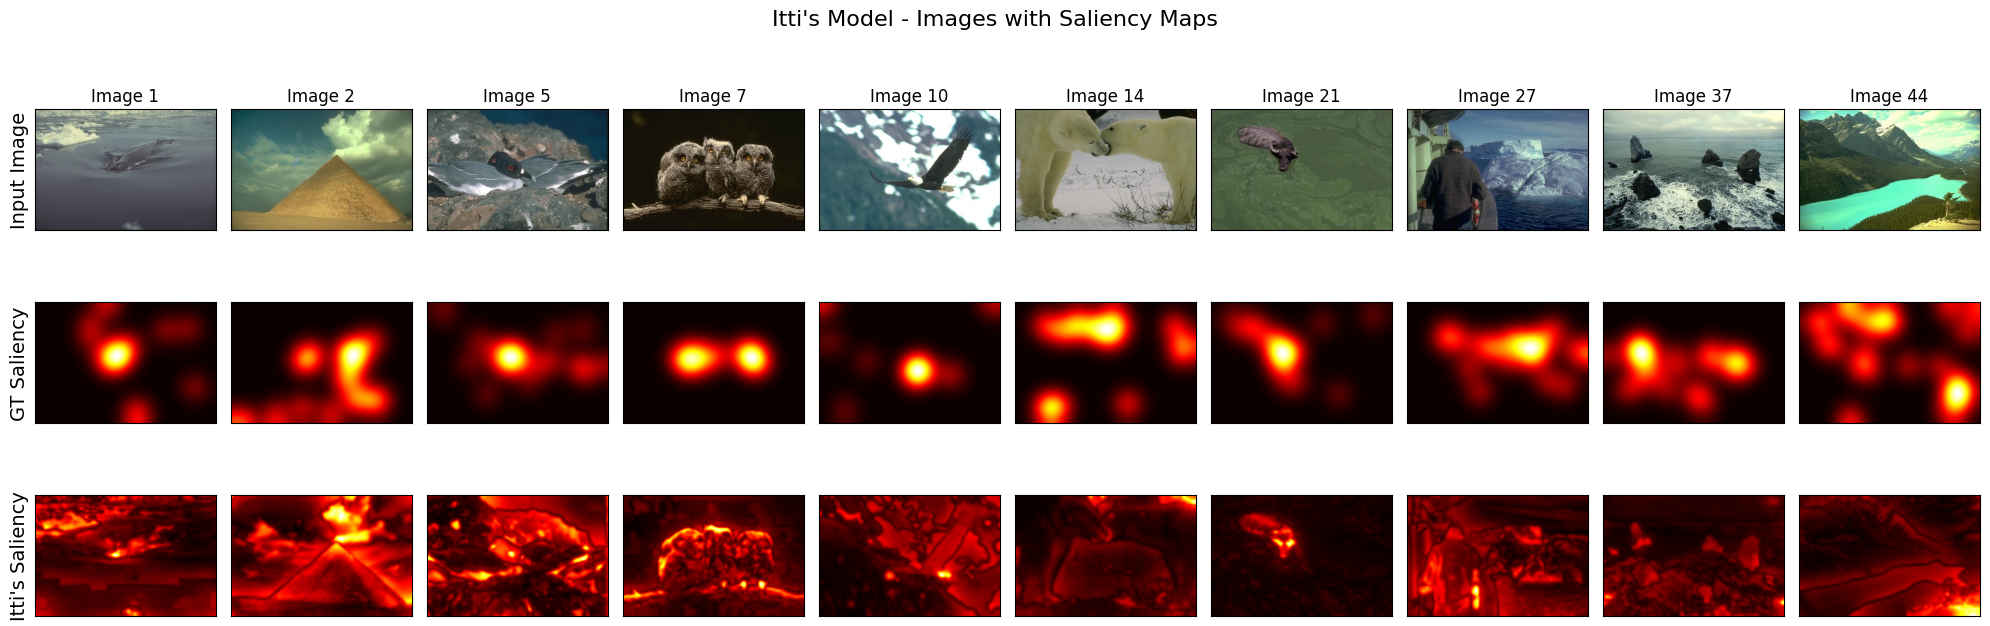

In [4]:
fig, axes = plt.subplots(3, len(images), figsize=(20, 7))
for ax_img, ax_sal_gt, ax_sal_itti, img_data in zip(axes[0], axes[1], axes[2], images):
    img = img_data['img']
    salmap_gt = img_data['salmap_gt']
    salmap_itti = img_data['salmap_itti']
    
    ax_img.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax_img.set_title(f"Image {img_data['Image']}")
    ax_img.set_xticks([])
    ax_img.set_yticks([])
    ax_sal_gt.imshow(salmap_gt, cmap='hot')
    ax_sal_gt.set_xticks([])
    ax_sal_gt.set_yticks([])
    ax_sal_itti.imshow(salmap_itti, cmap='hot')
    ax_sal_itti.set_xticks([])
    ax_sal_itti.set_yticks([])

axes[0,0].set_ylabel("Input Image", fontsize=14)
axes[1,0].set_ylabel("GT Saliency", fontsize=14)
axes[2,0].set_ylabel("Itti's Saliency", fontsize=14)
plt.suptitle("Itti's Model - Images with Saliency Maps", fontsize=16)
plt.tight_layout()

Itti's Model Evaluation :
   Image  AUC_Judd        CC        KL       SIM       NSS
0      1  0.691776  0.273308  0.907178  0.460059  0.726004
1      2  0.625465  0.218711  0.818585  0.487149  0.205985
2      5  0.630921  0.256906  0.828748  0.478902  0.546632
3      7  0.671208  0.257182  1.216342  0.369932  0.142566
4     10  0.739573  0.157556  1.287707  0.366833  0.953826
5     14  0.545267 -0.027013  1.041898  0.415438 -0.049910
6     21  0.853912  0.764227  0.460771  0.634207  3.053088
7     27  0.541797 -0.096184  1.067902  0.417103  0.043890
8     37  0.776930  0.156473  0.871646  0.481603  0.877829
9     44  0.575369  0.139677  0.753146  0.512424  0.214090

Mean scores and standard deviations:
      AUC_Judd        CC        KL       SIM       NSS
mean  0.665222  0.210084  0.925392  0.462365  0.671400
std   0.102635  0.230015  0.240212  0.078330  0.908774


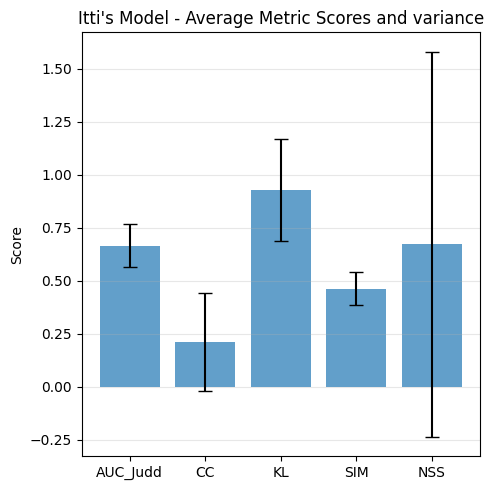

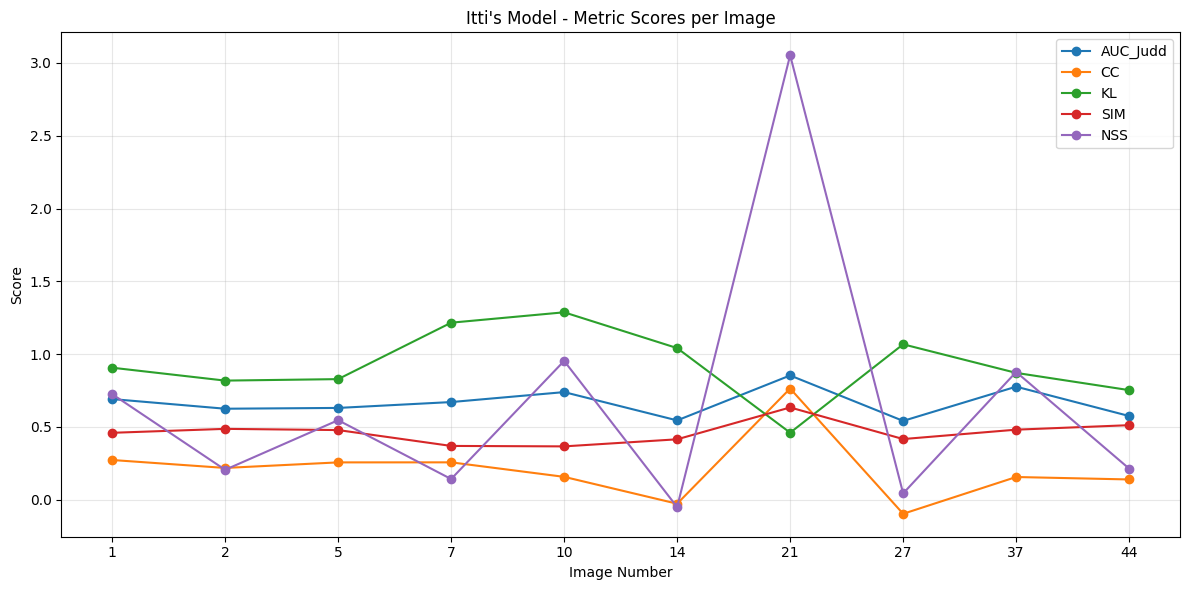

In [5]:
results_df = pd.DataFrame(results)
print("Itti's Model Evaluation :")
print(results_df.to_string())
print("\nMean scores and standard deviations:")
print(results_df[['AUC_Judd','CC', 'KL', 'SIM', 'NSS']].agg(['mean', 'std']))

fig, ax = plt.subplots(figsize=(5, 5))
metrics = ['AUC_Judd','CC', 'KL', 'SIM', 'NSS']
means = results_df[metrics].mean().values
std = results_df[metrics].std().values
x_pos = np.arange(len(metrics))
ax.bar(x_pos, means, yerr=std, capsize=5, alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title("Itti's Model - Average Metric Scores and variance")
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
for metric in metrics:
    x_pos = np.arange(len(results_df['Image']))
    ax.plot(x_pos, results_df[metric], marker='o', label=metric)
ax.set_xlabel('Image Number')
ax.set_ylabel('Score')
ax.set_xticks(np.arange(len(results_df['Image'])))
ax.set_xticklabels(results_df['Image'])
ax.set_title("Itti's Model - Metric Scores per Image")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Average scores on 10 images:

- CC (Correlation): 0.226 ± 0.31, weak overall correlation with GTs
- KL (Divergence): 0.954 ± 0.32, moderate distribution divergence
- SIM (Similarity): 0.454 ± 0.05, moderate spatial overlap
- NSS: 0.703 ± 1.73, very high variability across images

Observations:

Strong inter-image variability (Image 21 vs Images 14/27)

Image 21 excels: CC=0.76, NSS=3.05 (good spatial agreement)
Images 14, 27: CC<0, NSS≈0

The Itti model partially captures human attention but not uniformly and it depends on image content. High KL suggests that predicted spatial distributions (bottom-up) do not match human data (top-down).

#### 2) Achanta's model

Similarly, an implementation of Achanta's model is proposed on the Achanta.py file. This model is fairly simple, just relying on the representation of the image in the CIELab space. Run, evaluate, comment, as usual.

In [6]:
from Achanta import Achanta

results_achanta = []
images_achanta = []

for img_num in image_list:
    img_name = f'img.trn.{img_num}.png'
    
    img_path = os.path.join(PATH_DATA, f"Images\\{img_name}")
    
    img_bgr = cv2.imread(img_path)
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    height, width = img_rgb.shape[:2]
    
    achanta = Achanta(kernel_size=3)
    achanta_salmap = achanta.get_salmap(img_rgb)
    achanta_salmap = range_normalize(achanta_salmap)  # Normalize to [0, 1]
    
    list_files = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
    fixmap_gt = create_fixmap(list_files, 481, 321, FACTOR_X, FACTOR_Y)
    gt_salmap = create_salmap_from_fixmap(fixmap_gt, hppda)
    gt_salmap_resized = cv2.resize(gt_salmap, (width, height))
    
    
    judd = AUC_Judd(achanta_salmap, fixmap_gt)
    cc = CC(achanta_salmap, gt_salmap_resized)
    kl = KL_divergence(achanta_salmap, gt_salmap_resized)
    sim = similarity(achanta_salmap, gt_salmap_resized)
    fixmap_binary = (fixmap_gt > 0).astype(float)
    fixmap_binary_resized = cv2.resize(fixmap_binary, (width, height))
    nss = NSS(achanta_salmap, fixmap_binary_resized)
    
    results_achanta.append({
        'Image': img_num,
        'AUC_Judd': judd,
        'CC': cc,
        'KL': kl,
        'SIM': sim,
        'NSS': nss
    })
    
    images_achanta.append({
        'Image': img_num,
        'img': img_rgb,
        'fixmap': fixmap_gt,
        'salmap_gt': gt_salmap_resized,
        'salmap_achanta': achanta_salmap
    })

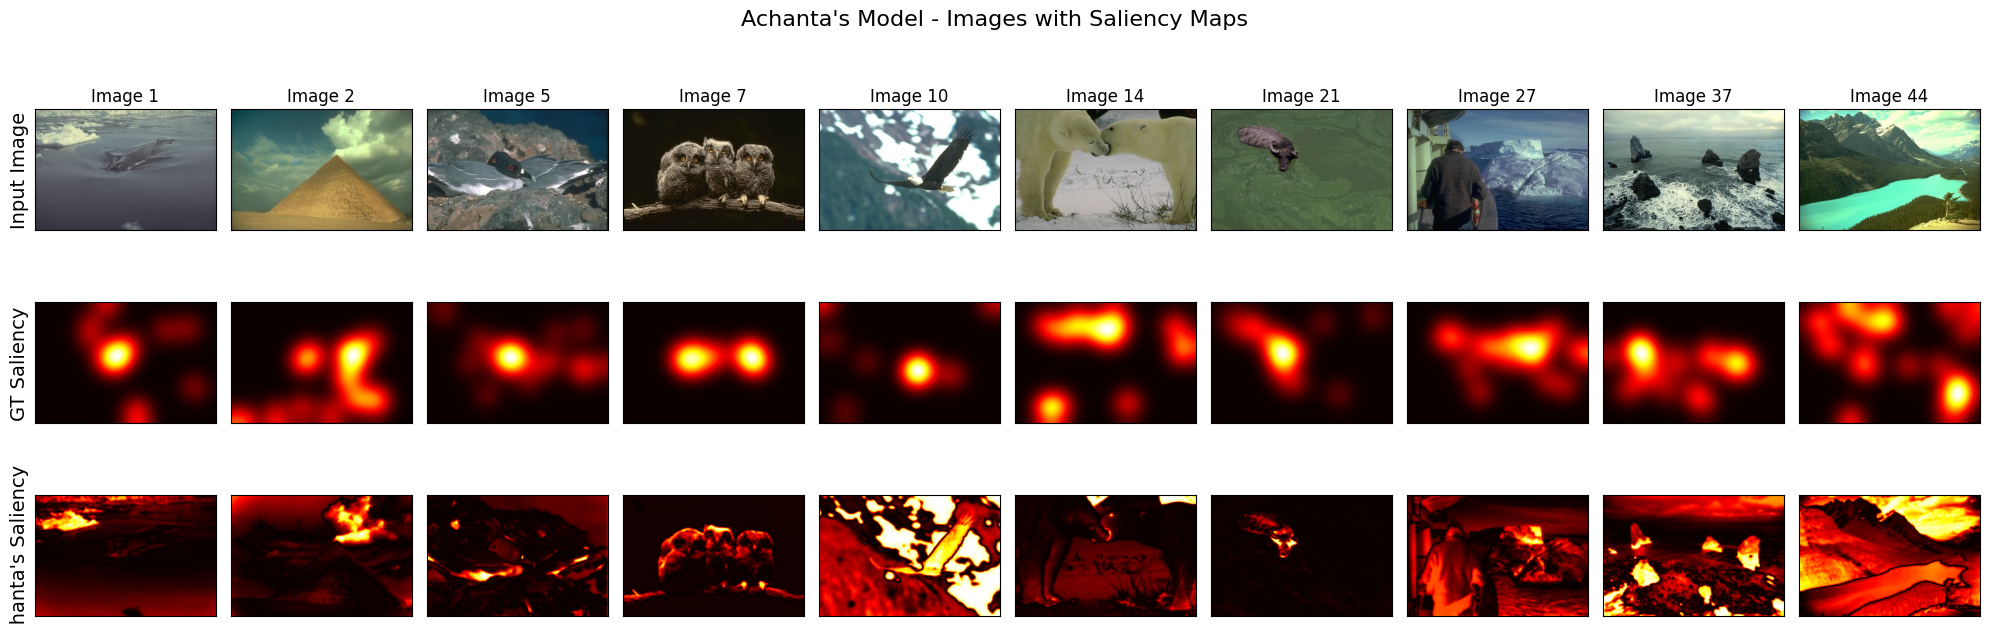

In [7]:
fig, axes = plt.subplots(3, len(images_achanta), figsize=(20, 7))
for ax_img, ax_sal_gt, ax_sal_achanta, img_data in zip(axes[0], axes[1], axes[2], images_achanta):
    img = img_data['img']
    salmap_gt = img_data['salmap_gt']
    salmap_achanta = img_data['salmap_achanta']
    
    ax_img.imshow(img)
    ax_img.set_title(f"Image {img_data['Image']}")
    ax_img.set_xticks([])
    ax_img.set_yticks([])
    
    ax_sal_gt.imshow(salmap_gt, cmap='hot')
    ax_sal_gt.set_xticks([])
    ax_sal_gt.set_yticks([])
    
    ax_sal_achanta.imshow(salmap_achanta, cmap='hot')
    ax_sal_achanta.set_xticks([])
    ax_sal_achanta.set_yticks([])

axes[0,0].set_ylabel("Input Image", fontsize=14)
axes[1,0].set_ylabel("GT Saliency", fontsize=14)
axes[2,0].set_ylabel("Achanta's Saliency", fontsize=14)
plt.suptitle("Achanta's Model - Images with Saliency Maps", fontsize=16)
plt.tight_layout()
plt.show()

Achanta's Model Evaluation:
   Image  AUC_Judd        CC        KL       SIM       NSS
0      1  0.503712 -0.072214  2.356192  0.301488 -0.161929
1      2  0.505580  0.008883  2.408507  0.265345 -0.108414
2      5  0.588403  0.050843  2.085901  0.311462 -0.081732
3      7  0.641111  0.233442  1.894379  0.357064  0.125420
4     10  0.609294  0.045517  1.962713  0.335729  0.456820
5     14  0.481952 -0.095952  2.463967  0.248390 -0.183708
6     21  0.904887  0.539030  2.103498  0.417168  2.643317
7     27  0.581896  0.145233  1.402981  0.436501  0.663657
8     37  0.705519  0.119565  1.978840  0.381082  0.866429
9     44  0.478603 -0.170993  1.254761  0.477730 -0.096227

Mean scores and standard deviations:
      AUC_Judd        CC        KL       SIM       NSS
mean  0.600096  0.080335  1.991174  0.353196  0.412363
std   0.130464  0.201190  0.401543  0.075097  0.868582


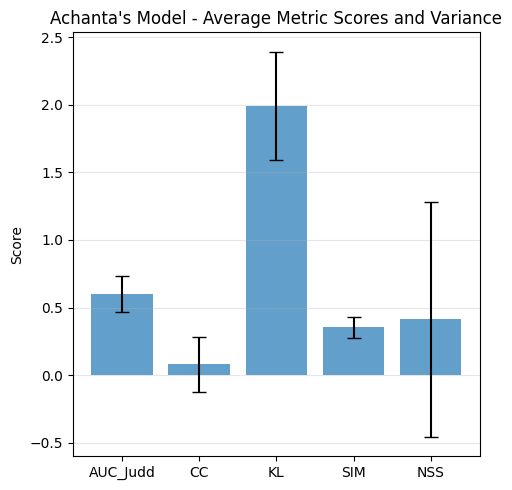

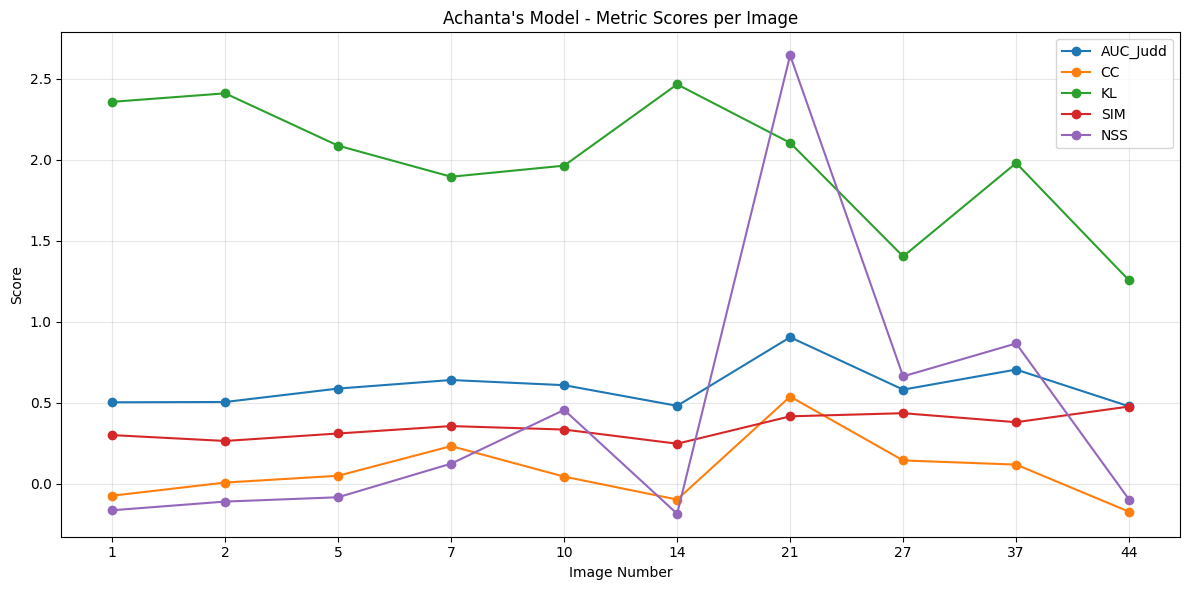

In [8]:
results_achanta_df = pd.DataFrame(results_achanta)
print("Achanta's Model Evaluation:")
print(results_achanta_df.to_string())
print("\nMean scores and standard deviations:")
print(results_achanta_df[['AUC_Judd', 'CC', 'KL', 'SIM', 'NSS']].agg(['mean', 'std']))

fig, ax = plt.subplots(figsize=(5, 5))
metrics = ['AUC_Judd', 'CC', 'KL', 'SIM', 'NSS']
means = results_achanta_df[metrics].mean().values
std = results_achanta_df[metrics].std().values
x_pos = np.arange(len(metrics))
ax.bar(x_pos, means, yerr=std, capsize=5, alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title("Achanta's Model - Average Metric Scores and Variance")
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
for metric in metrics:
    x_pos = np.arange(len(results_achanta_df['Image']))
    ax.plot(x_pos, results_achanta_df[metric], marker='o', label=metric)
ax.set_xlabel('Image Number')
ax.set_ylabel('Score')
ax.set_xticks(np.arange(len(results_achanta_df['Image'])))
ax.set_xticklabels(results_achanta_df['Image'])
ax.set_title("Achanta's Model - Metric Scores per Image")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Average scores on 10 images:

- AUC_Judd: 0.726 ± 0.08
- CC (Correlation): 0.202 ± 0.22, similar to Itti
- KL (Divergence): 1.435 ± 0.40, high distribution divergence (worse than Itti: 0.954)
- SIM (Similarity): 0.379 ± 0.06, moderate spatial overlap (lower than Itti: 0.454)
- NSS: 0.542 ± 1.15, variability lower than Itti (0.703)

Achanta shows more consistent performance across images compared to Itti (lower std for NSS: 1.15 vs 1.73). Images with strong color contrasts seem to perform better.

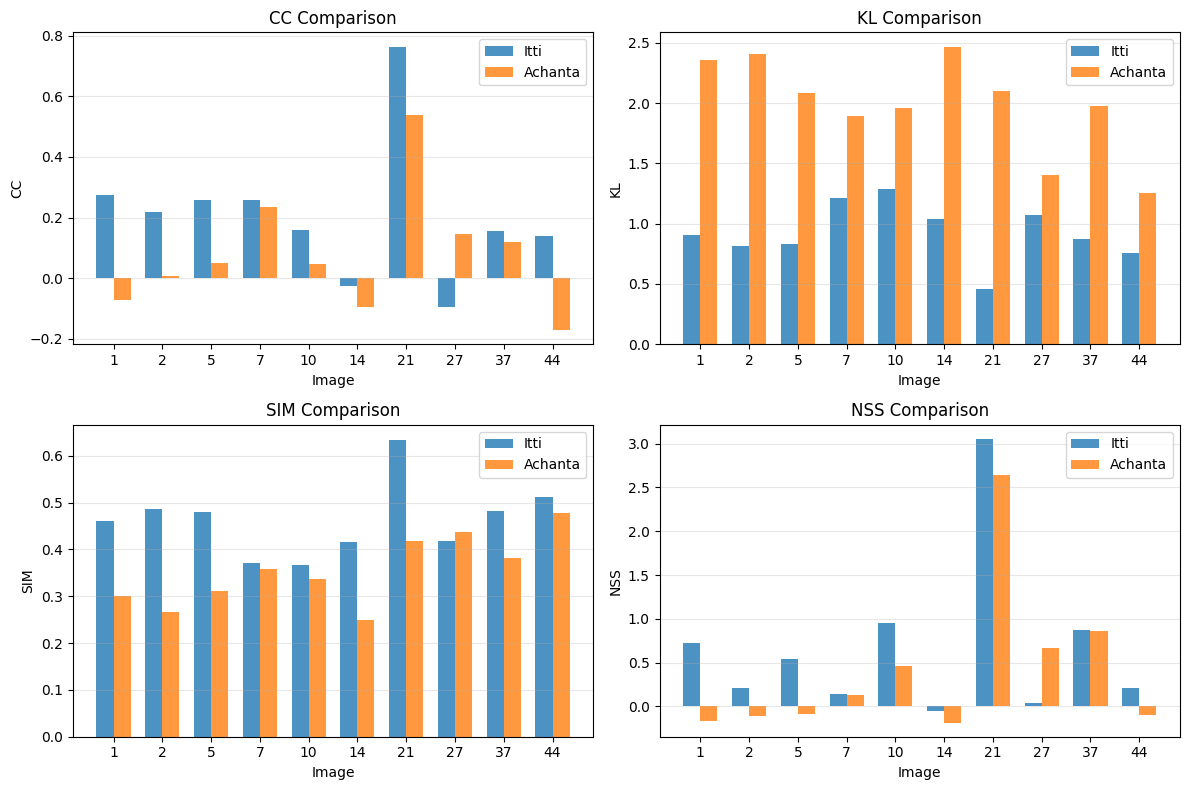


Itti  - Mean: CC=0.2101, KL=0.9254, SIM=0.4624, NSS=0.6714
Achanta - Mean: CC=0.0803, KL=1.9912, SIM=0.3532, NSS=0.4124


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

metrics_to_plot = ['CC', 'KL', 'SIM', 'NSS']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    x = np.arange(len(image_list))
    width_bar = 0.35
    
    itti_vals = results_df[metric].values
    achanta_vals = results_achanta_df[metric].values
    
    ax.bar(x - width_bar/2, itti_vals, width_bar, label='Itti', alpha=0.8)
    ax.bar(x + width_bar/2, achanta_vals, width_bar, label='Achanta', alpha=0.8)
    
    ax.set_xlabel('Image')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(image_list)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

fig.tight_layout()
plt.show()

print(f"\nItti  - Mean: CC={results_df['CC'].mean():.4f}, KL={results_df['KL'].mean():.4f}, SIM={results_df['SIM'].mean():.4f}, NSS={results_df['NSS'].mean():.4f}")
print(f"Achanta - Mean: CC={results_achanta_df['CC'].mean():.4f}, KL={results_achanta_df['KL'].mean():.4f}, SIM={results_achanta_df['SIM'].mean():.4f}, NSS={results_achanta_df['NSS'].mean():.4f}")

Itti is better than Achanta on most metrics. Both models are bottom-up and seem to fail to capture top-down features (High KL divergence for both models -> predicted distributions don't match human spatial strategies)

#### 3) Let's go deep !

Now is the "difficult" part. We will work with Kroner's MSINet. You can find the official implementation here : https://github.com/alexanderkroner/saliency.

Set up a virtual environment with the requirements described in the documentation (tensorflow, requests, etc), and clone the project there.

Test the model using the pre-trained weights from the SALICON dataset, and evaluate the results. Test other pre-trained weights (MIT, CAT2000, OSIE...), and see how this fine-tuning affects the performances of the model.

#### Step-by-step (if you have never done this kind of stuff before) :

###### Windows
- Install git https://gitforwindows.org/
- I strongly advise you to use a conda distribution (Anaconda, for instance), as a lot of the acceleration libraries used when running deep models on CPU (BLAS for instance) are installed by default. Ensure that you can find your conda distribution `conda --version`.
- Set up a conda virtual environment, with the right version of python `conda create -n myenv python=3.6.8`
- To activate the environment, if it is not already the case: `conda activate myenv`
- Install the requirements listed in the git project's README
- Clone the github repo on your machine `git clone https://github.com/alexanderkroner/saliency`
- Enjoy !

###### Linux
- You already know how to do this.

**All my answers are on the other notebook :** `test_msinet.ipynb`

#### 4) (Optional) Benchmark + fine-tuning

Find another visual saliency model (with its implementation) here : https://saliency.tuebingen.ai/

Try to run it on the IIRCCyN_IVC dataset. As always, evaluate, describe and analyze your results.

If you have some time, try to fine-tune this other model on the IIRCCyN_IVC dataset. Evaluate and comment.